In [135]:
# geemap is the most useful module to work with Google Earth Engine data in Python: https://github.com/giswqs/geemap

# Installs geemap package
import subprocess
try:
    import geemap
except ImportError:
    print('geemap package not installed. Installing ...')
    subprocess.check_call(["python", '-m', 'pip', 'install', 'geemap'])

# Authenticates and initializes Earth Engine (you need to sign up there in advance):
import ee

try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize()  
    
import tensorflow as tf  
import matplotlib.pyplot as plt
import tifffile as tiff
import random
import numpy as np
from skimage import io
import os, shutil, sys, time
import pandas as pd
from glob import glob
import rasterio
import time
import datetime
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import keras

# import osgeo
# import osgeo.ogr as ogr
import rasterstats as rs
from rasterio.plot import show
import osr
import gdal
import geopandas as gpd

! python -V
print('TensorFlow version: ', tf.__version__)
print('EE version:', ee.__version__)

Python 3.8.5
TensorFlow version:  2.4.0
EE version: 0.1.251


In [3]:
# This is the simple and nice way to make a new interactive map in geemap module
# Usually I make several of them to vizualize different data

Lap = geemap.Map(center=[61,68], zoom=8) # change coordinates of the map center and zoom level
Map = geemap.Map(center=[61,68], zoom=8)
Gap = geemap.Map(center=[61,68], zoom=8)

Map # Name which map to vizualize
# Lap
# Gap

Map(center=[61, 68], controls=(WidgetControl(options=['position'], widget=HBox(children=(ToggleButton(value=Fa…

In [4]:
# !!! Draw any shapes on the map using the Drawing tools !!!
# GEE works better with regions of interests (roi), so just draw a rectangular on a map and execute the block
feature = Map.draw_last_feature
roi = feature.geometry()

# Creating Training and Test Set

### Import of Training Areas from GEE

Choose your asset using geemap.ee_search() or insert your polygon ID into the "ee.FeatureCollection(...ID...)"

In [5]:
# geemap.ee_search() # the simple way to import assets from GEE or read the documentation

### Training polygons

In [11]:
# Import theory polygons of seeps:
seeps_theory_poly = ee.FeatureCollection('users/irro/seeps_theory_poly_26mar_3')
seeps_theory_poly = seeps_theory_poly.map(lambda f: f.buffer(2)) 
Lap.addLayer(seeps_theory_poly, {'color': 'red'}, "seeps_theory_poly")

# Import really visited polygons of seeps:
seeps_real_poly = ee.FeatureCollection('users/irro/seeps_real_poly_14Feb2')
Lap.addLayer(seeps_real_poly, {'color': 'pink'}, "seeps_real_poly")

# Import water polygons without seeps:
seeps_water_poly = ee.FeatureCollection('users/irro/seeps_water_wet_26mar')
Lap.addLayer(seeps_water_poly, {'color': 'blue'}, "seeps_water_poly")

# Import polygons with NO seeps and NO water:
nothing_poly = ee.FeatureCollection('users/irro/seeps_no_26mar') 
Lap.addLayer(nothing_poly, {'color': 'yellow'}, "nothing_poly")

# Vizualize our polygons
Lap

Map(bottom=18962.0, center=[61, 68], controls=(WidgetControl(options=['position'], widget=HBox(children=(Toggl…

In [12]:
#Это НЕ трейнинг точки, это области, где нет сипов для классификации в инпут CNN "ничего-вода"
noseeps_areas = ee.FeatureCollection('users/irro/seepsno_areas_25mar')
Lap.addLayer(noseeps_areas, {'color': 'brown'}, "noseeps_areas")

### Training points (random from polygons)

In [13]:
# !!! Assign random points inside polygons !!!
# 500-2000-5000-1000-2000: work the best way ('1st option')
seeps_real_points = ee.FeatureCollection.randomPoints(seeps_real_poly,500,seed = 41)
seeps_theory_points = ee.FeatureCollection.randomPoints(seeps_theory_poly,2000,seed = 41)
nothing_points = ee.FeatureCollection.randomPoints(nothing_poly,5000,seed = 41)
seeps_water_points = ee.FeatureCollection.randomPoints(seeps_water_poly,1000,seed = 41)

# lake_points are used ONLY to make squares in wetland and floodplain areas with no seeps
lake_points = ee.FeatureCollection.randomPoints(noseeps_areas,2000,seed = 41)

# Set "label" to each random poing. Label 0 - 'other objects'. Set the function:
def func_other(feature):
    return ee.Feature(feature).set('label', 0)
# Set label to our random points using function:
nothing_points = nothing_points.map(func_other)

# Set "label" to each random poing. Label 1 - 'seeps'. Set the function:
def func_seeps(feature):
    return ee.Feature(feature).set('label', 1)
# Set label to our random points using function:
seeps_real_points = seeps_real_points.map(func_seeps)
seeps_theory_points = seeps_theory_points.map(func_seeps)

# Set "label" to each random poing. Label 2 - 'water'. Set the function:
def func_water(feature):
    return ee.Feature(feature).set('label', 2)
# Set label to our random points using function:
water = seeps_water_points.map(func_water)

# Make GEE featurecollection from random points with label:
seeps_real_points = ee.FeatureCollection(seeps_real_points)
seeps_theory_points = ee.FeatureCollection(seeps_theory_points)
nothing_points = ee.FeatureCollection(nothing_points)
water = ee.FeatureCollection(water)

# Add random points to the map ("Lap")
Lap.addLayer(seeps_real_points, {'color': 'red'},'seeps_real_points')
Lap.addLayer(seeps_theory_points, {'color': 'orange'},'seeps_theory_points')
Lap.addLayer(lake_points, {'color': 'brown'},'lake_points')
Lap.addLayer(water, {'color': 'blue'}, 'water')
Lap.addLayer(nothing_points, {'color': 'yellow'},'nothing_points')

### Make different training points

-> RF_points are points with label 0 ("other") and label 1 (seeps) with NO water points. They are used to make a seeps-other map which is a base map to add the "water mask" map

-> noseeps_points are points with areas with no seeps. They include only label 0 ("other") and label 2 ("water") with NO seeps. They are used to make water-other map in areas with no seeps. For example, wetland lake edges are often misclassified as seep areas, but in reality they have NO seeps! Or some floodplain lakes are very similar to seep areas and often misclassified. We assign "noseeps_points" to have good training set for such challenging areas!

-> train_points are all points including lake_points with NO label. They are used to make square buffer around only. So it's just all points to cut squares for CNN. You make add more points here (with or without label) to have more squares. BUT. The area inside squares should be well classified with Random Forest (no challenging objects).

In [14]:
noseeps_points = ee.FeatureCollection([nothing_points,water]).flatten(); 
RF_points = ee.FeatureCollection([seeps_real_points,seeps_theory_points,nothing_points]).flatten();
train_points = ee.FeatureCollection([lake_points,seeps_real_points,seeps_theory_points,nothing_points,water]).flatten();

## Test Points for Accuracy Assessment

In [15]:
# !!! Choose new seed to assign random points inside polygons !!!
# 2000 points for each class!
test_seeps_real_points = ee.FeatureCollection.randomPoints(seeps_real_poly,500,seed = 1)
test_seeps_theory_points = ee.FeatureCollection.randomPoints(seeps_theory_poly,1500,seed = 1)
test_nothing_points = ee.FeatureCollection.randomPoints(nothing_poly,2000,seed = 1)
test_seeps_water_points = ee.FeatureCollection.randomPoints(seeps_water_poly,2000,seed = 1)
test_lake_points = ee.FeatureCollection.randomPoints(noseeps_areas,2000,seed = 1)

# Set label to our random points using abovementioned functions:
test_nothing_points = test_nothing_points.map(func_other)
test_seeps_real_points = test_seeps_real_points.map(func_seeps)
test_seeps_theory_points = test_seeps_theory_points.map(func_seeps)
test_water = test_seeps_water_points.map(func_water)

# Make GEE featurecollection from random points with label:
test_seeps_real_points = ee.FeatureCollection(test_seeps_real_points)
test_seeps_theory_points = ee.FeatureCollection(test_seeps_theory_points)
test_nothing_points = ee.FeatureCollection(test_nothing_points)
test_water = ee.FeatureCollection(test_water)

# Make GEE featurecollection with all points:
test_points = ee.FeatureCollection([test_seeps_real_points,test_seeps_theory_points,test_nothing_points,test_water]).flatten();

### Export point to Google Drive (and then download to the local computer)

In [ ]:
Task = ee.batch.Export.table.toDrive(
        collection=test_points,          
        description='Export batch',
        fileNamePrefix='test_2000points_cnn64',
        folder='EE',  
        fileFormat='SHP')
Task.start()

# Making Labeled Map for CNN

### Mask of Water and Other objects using OpenStreetMap

OpenStreetMap (OSM) data was recently available to download directly. Not it's not so easy. We imported our local OSM vector data to GEE and the import them from GEE to Python using geemap. Sounds long, but it's not difficult. The idea is simple - to GEEfy OSM data to be able to use them with GEE functions and mosaics.

In [16]:
# Import landuse areas:
dataset_xjt = ee.FeatureCollection('users/irro/KHMAO-OSM/landuse')

# Import settlement areas:
dataset_pym = ee.FeatureCollection('users/irro/KHMAO-OSM/settlements')
settlements = dataset_pym.map(func_other)

# Import highway areas with buffer zone around:
dataset_vdq = ee.FeatureCollection('users/irro/KHMAO-OSM/highway-line')
highways = dataset_vdq.map(lambda f: f.buffer(50)) 
highways = highways.map(func_other)

# Import vegetation areas:
vegetation = ee.FeatureCollection('users/irro/KHMAO-OSM/vegetation')
vegetation = vegetation.map(func_other)

# Import buildings with buffer zone around:
dataset_sjt = ee.FeatureCollection('users/irro/KHMAO-OSM/buildings')
buildings = dataset_sjt.map(lambda f: f.buffer(50)) 
buildings = buildings.map(func_other)

# Import lake and water areas:
water_areas = ee.FeatureCollection('users/irro/KHMAO-OSM/water')
lake_areas = ee.FeatureCollection.filterMetadata(water_areas, 'NATURAL', 'equals', 'water')
lake_areas = lake_areas.map(func_water)

# Import river areas:
riverbank = ee.FeatureCollection.filterMetadata(water_areas, 'WATERWAY', 'equals', 'riverbank')
riverbank = riverbank.map(func_water)

# Import river lines(!):
dataset_qxb = ee.FeatureCollection('users/irro/KHMAO-OSM/water-line')
# streems and small rivers:
streams = ee.FeatureCollection.filterMetadata(dataset_qxb, 'WATERWAY', 'equals', 'stream')
rivers = ee.FeatureCollection.filterMetadata(dataset_qxb, 'WATERWAY', 'equals', 'river')
#Buffer of different size around:
streams = streams.map(lambda f: f.buffer(2)) 
streams = streams.map(func_water)
#Buffer of different size around:
rivers = rivers.map(lambda f: f.buffer(4)) 
rivers = rivers.map(func_water)

### Rasterize OSM layers to add the label

In [17]:
# Растеризуем слой полигонов для добавления к сентинелю
highway_raster = highways.reduceToImage(['label'],ee.Reducer.first()).rename('classification')
Lap.addLayer(highway_raster, {'color': 'grey'}, 'highway_raster')

vegetation_raster = vegetation.reduceToImage(['label'],ee.Reducer.first()).rename('classification')
Lap.addLayer(vegetation_raster, {'color': 'green'}, 'vegetation_raster')

buildings_raster = buildings.reduceToImage(['label'],ee.Reducer.first()).rename('classification')
Lap.addLayer(buildings_raster, {'color': 'grey'}, 'buildings_raster')

streams_raster = streams.reduceToImage(['label'],ee.Reducer.first()).rename('classification')
Lap.addLayer(streams_raster, {'min': 0, 'max': 50000000, 'palette': ['blue']}, 'streams_raster')

rivers_raster = rivers.reduceToImage(['label'],ee.Reducer.first()).rename('classification')
Lap.addLayer(rivers_raster, {'min': 0, 'max': 50000000, 'palette': ['red']}, 'rivers_raster')

riverbank = riverbank.reduceToImage(['label'],ee.Reducer.first()).rename('classification')
Lap.addLayer(riverbank, {'min': 0, 'max': 50000000, 'palette': ['black']}, 'riverbank')

lake_areas = lake_areas.reduceToImage(['label'],ee.Reducer.first()).rename('classification')
Lap.addLayer(lake_areas, {'min': 0, 'max': 50000000, 'palette': ['black']}, 'lake_areas')

settlements = settlements.reduceToImage(['label'],ee.Reducer.first()).rename('classification')
Lap.addLayer(settlements, {'color': 'grey'}, 'settlements')

landuse = dataset_xjt.reduceToImage(['OSM_ID'],ee.Reducer.first())
Lap.addLayer(landuse, {'color': 'grey'}, 'landuse')

Lap

Map(bottom=149325.0, center=[61.089935958498515, 69.28113718576702], controls=(WidgetControl(options=['positio…

## Sentinel-1 Data Preparation (for a water mask only)

In [18]:
# Function for SE-1 to cut edges by a threshold
def SE1edge(image):
    edge = image.lt(-30.0)
    maskedImage = image.mask().And(edge.Not())
    return image.updateMask(maskedImage)

# Function for SE-1: incidence angle normalization
def SE1incCorr(image):
    power = 0.80; # оптимальное значение = 0.80
    ANGL = image.select('angle')
    VV = image.select('VV')
    RAD = image.expression(
        'cos(ANGL * 3.14159265359 / 180)',
        {'ANGL': ANGL, 'VV' : VV})
    POWRAD = RAD.pow(power)
    corrected = VV.multiply(POWRAD)
    return corrected

# Function of angle filtration
def SE1angle(image):
    minAngle = 30.0
    maxAngle = 46.0
    # Get the pixel angle band.
    ANGL = image.select('angle')
    mask = ANGL.expression(
        'ANGL >= minAngle && ANGL <= maxAngle',
        {'ANGL': ANGL, 'minAngle':minAngle, 'maxAngle':maxAngle})
    return image.updateMask(mask)

In [19]:
# Import of Sentinel-1 (SE1) data from GEE:
collection = ee.ImageCollection('COPERNICUS/S1_GRD')
# Filter its bounds by the region of interest (roi, drawn manually)
collection = collection.filterBounds(roi)
collection = collection.filter(ee.Filter.eq('instrumentMode', 'IW'))

# Filter data by year and the season (with no snow and no melted water)
yearRange  = ee.Filter.calendarRange(2014,2020,'year')
collection = collection.filter(yearRange)
collection = collection.filter(ee.Filter.calendarRange(180, 280, 'day_of_year'))

# Use functions to normalize angles and cut edges:
collection = collection.map(SE1edge); # обрезка краев
collection = collection.map(SE1angle); # обрезка углов
corrected = collection.map(SE1incCorr); # incidence angle normalization

# !!! Making a median product !!!
# Each pixel is a median of all SE1 pixels for a givern year range and season:
SE1 = corrected.select(['VV']).limit(10000).median()
# Slightly smooth the mosaic to reduce noises
SE1_smoothed = SE1.focal_median(radius=3,kernelType='circle');

# Parameters for vizualization of SE1 images:
visParams = {
  'min': -15,
  'max':  5,
  'gamma': 1.8,}

visParams2 = {
  'min': -12, #-15
  'max': -7,  # 15
  'gamma': 1.8,}

Map.addLayer(SE1_smoothed, visParams, 'SE1')
Map

Map(bottom=2602.0, center=[61.64816245852389, 74.28955078125001], controls=(WidgetControl(options=['position']…

## Sentinel-2 data preparation for CNN

In [20]:
# Function for cloud masking by QA60 channel
def maskS2clouds1(image):
    qa = image.select('QA60')

    # Bits 10 and 11 are clouds and cirrus, respectively.
    cloudBitMask = (1 << 10)
    cirrusBitMask = (1 << 11)

    # Both flags should be set to zero, indicating clear conditions.
    mask = qa.bitwiseAnd(cloudBitMask).eq(0) \
    .And(qa.bitwiseAnd(cirrusBitMask).eq(0))
    return image.updateMask(mask)

In [21]:
# Import Sentinel-2 (SE2) from GEE imagecollection and select channels / filter bounds / filter dates
SE2_collection = ee.ImageCollection('COPERNICUS/S2_SR').select('B3', 'B4', 'B8', 'B11', 'QA60') \
    .filterBounds(roi) \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE',20)) \
    .filter(ee.Filter.calendarRange(140, 280, 'day_of_year')) \
    .filterDate('2015-01-01', '2021-01-01')

# Cloud Masking
SE2_collection = SE2_collection.map(maskS2clouds1)

# Select final input channels for SE2
SE2_collection = SE2_collection.select('B3', 'B4', 'B8', 'B11')

### Making seasonal Sentinel-2 composites

In [22]:
# Choose season duration:
spring = ee.Filter.calendarRange(122, 163, 'day_of_year');
summer = ee.Filter.calendarRange(122, 228, 'day_of_year'); #до конца половодья якобы
autumn = ee.Filter.calendarRange(205, 275, 'day_of_year');

# Making seasonal composits (filtering by dates and making a median composite for such dates):
SE2_summer = SE2_collection.filter(summer);
SE2_summer = SE2_summer.median().uint16();

SE2_spring = SE2_collection.filter(spring);
SE2_spring = SE2_spring.median().uint16();

SE2_autumn = SE2_collection.filter(autumn);
SE2_autumn = SE2_autumn.median().uint16();
# Normalizing autumn median mosaic to make an input for CNN:
SE2_autumn_ToExport = SE2_autumn.multiply(0.0001)

# Full season composite:
SE2_median = SE2_collection.median().uint16();

# Vizualization parameters for SE2
SE2_visParams = {
  'bands': ['B8', 'B11', 'B4'], 
  'min': [0, 0, 0],
  'max': [4000, 2000, 1000],
  'gamma': 1}

# Vizualization parameters for normalized image:
SE2_visParams_2 = {
  'bands': ['B8', 'B11', 'B4'], 
  'min': [0, 0, 0],
  'max': [0.4000, 0.2000, 0.1000],
  'gamma': 1}

Map.addLayer(SE2_autumn, SE2_visParams, 'SE2_autumn');
Map.addLayer(SE2_spring, SE2_visParams, 'SE2_spring');

Map

Map(bottom=149429.0, center=[61.055294697995436, 69.19429779052736], controls=(WidgetControl(options=['positio…

In GEE we assigned numerous areas with no seeps but with many other objects that could be easily misclassified as seeps. For example, floodplain lakes and wetland areas. So SE2_noseeps is a layer with Sentinel-2 mosaick for such areas. We use it to assign training data without errors between seeps-water in the most challenging parts.

In [25]:
# Обрезаем сентинель в областях, где ТОЧНО нет сипов, чтобы его классифицировать и выбрать по ним точки вода-ничего
SE2_noseeps = SE2_autumn.clip(noseeps_areas);
Map.addLayer(SE2_noseeps, SE2_visParams, 'SE2_noseeps');

### Masking non-floodplain areas by spring NDVI composite

NDVI composite is great to make a mask of floodplains and water areas. It's important to add streams and rivers from OSM to the mask, because NDVI alone is not enough to catch them due to small sizes.

In [23]:
# Calculate NDVI by summer Sentinel-2 median mosaic:
ndvi_summer = SE2_summer.normalizedDifference(['B8', 'B4'])
# Assign NDVI threshold for masking:
ndvi_threshold_summer = 0.5
# Thresholding NDVI composite to mask non-flooded and non-water areas
water_ndvi_summer = ndvi_summer.lt(ndvi_threshold_summer).selfMask()
Map.addLayer(ndvi_summer, {}, 'ndvi_summer');

Updating NDVI water mask by Sentinel-1 threshold value

In [29]:
# Masking water by Sentinel-1 threshold after noise reduction:
SE1_mask_smoothed = SE1_smoothed.lt(-14.5).selfMask()

# Updating NDVI mask by Sentinel-1 threshold
SE1_watermask_SE2 = SE1_mask_smoothed.updateMask(water_ndvi_summer)
Map.addLayer(SE1_watermask_SE2, {'min': 0, 'max': 2, 'palette': legend_colors_2}, 'SE1_watermask_SE2');

### Adding OSM vector data to catch small rivers and streams

In [24]:
# Adding rasterized OSM layers with rivers, streams and water ares to the mask
mask = ee.Image.blend(water_ndvi_summer,lake_areas)#.rename()
mask = ee.Image.blend(mask,riverbank)#.rename()
mask = ee.Image.blend(mask,rivers_raster)#.rename()

# Final mask by NDVI with added OSM data
ndvi_OSM_mask = ee.Image.blend(mask,streams_raster)#.rename()

Map.addLayer(ndvi_OSM_mask, {'min': 0, 'max': 3, 'palette': ['red']}, 'ndvi_OSM_mask');

### Updating Sentinel-2 mosaic by water mask for input to CNN

In [26]:
# Exclude non-flooded and non-water aread from autumn Sentinel-2 mosaic
SE2_autumn_ndvi = SE2_autumn.updateMask(ndvi_OSM_mask) # masking autumn Sentinel mosaic

# Adding water-other areas with NO seeps to Sentinel-2 mosaic
SE2_autumn_ndvi = ee.Image.blend(SE2_autumn_ndvi,SE2_noseeps)

# Normalizing Sentinel-2 data for CNN input
SE2_autumn_ndvi_ToExport = SE2_autumn_ndvi.multiply(0.0001)

Map.addLayer(SE2_autumn_ndvi, SE2_visParams, 'SE2_autumn_ndvi');

# Preparation of Labeled Sentinel-2 Data using Random Forest

CNN input requires squares of 32 px (and more) size, each of them should have Sentinel-2 data and the label information for each pixel. Since it's extremely hard to make manually (too much of data to label) and we have no prior information (e.g. some vector layers with seeps), the single option was to map all squares using Random Forest method and then feed it as a label to CNN.

Of course, Random Forest has its drawbacks. But they were minimized by multistep procedure of masking and taking the simplest area to classify as an input. So yeah, generally Random Forest is not suitable for seep mapping, but it produces good results at our wisely chosen squares with multiple masks.

### Random Forest classification of Sentinel-2 (only seeps and other, NO water)

In [30]:
bands = ['B3', 'B4', 'B8', 'B11']

training = SE2_autumn.select(bands).sampleRegions(**{
  'collection': RF_points, # points to train
  'properties': ['label'], # label data for each point
  'scale': 10,
  'geometries': True
})

classifier = ee.Classifier.smileRandomForest(**{
  'numberOfTrees': 200,    
  'minLeafPopulation': 2, 
  'bagFraction': 0.5,  
  'seed': 0               
  });

# Train the classifier using label data
classifier = classifier.train(training, 'label')

# Classify autumn Sentinel-2 mosaic into two classes: seeps and other (NO water! It will be added further)
SE2_autumn_nowater = SE2_autumn.select(bands).classify(classifier).rename('classification').float() #!!! Добавлен тип данных
# Reduce some noises:
SE2_autumn_nowater_smoothed = SE2_autumn_nowater.focal_median(radius=2,kernelType='circle');

legend_keys = ['noseeps', 'seeps', 'water']
legend_colors = ['white', 'yellow', 'black']

Map.addLayer(SE2_autumn_nowater_smoothed, {'min': 0, 'max': 2, 'palette': legend_colors}, 'SE2_autumn_nowater_smoothed')

### Random Forest classification of open water areas (NO seeps)

In [31]:
training = SE2_autumn.select(bands).sampleRegions(**{
  'collection': noseeps_points, # points include only water and other classes
  'properties': ['label'],
  'scale': 10,
  'geometries': True
})

classifier = ee.Classifier.smileRandomForest(**{
  'numberOfTrees': 200,    
  'minLeafPopulation': 10, 
  'bagFraction': 0.5, 
  'seed': 0               
  });

# Обучаем классификатор
classifier = classifier.train(training, 'label')

SE2_lakes = SE2_noseeps.select(bands).classify(classifier).rename('classification') #.float() #!!! Добавлен тип данных
SE2_lakes_smoothed = SE2_lakes.focal_median(radius=4,kernelType='circle');

legend_keys = ['noseeps', 'seeps', 'water']
legend_colors = ['white', 'yellow', 'black']

Map.addLayer(SE2_lakes_smoothed, {'min': 0, 'max': 2, 'palette': legend_colors}, 'SE2_lakes')
Map

Map(bottom=75008.0, center=[60.95977734817571, 69.3340301513672], controls=(WidgetControl(options=['position']…

### Join all masks together to get the final image

In [32]:
SE2_SE1 = ee.Image.where(SE2_autumn_nowater_smoothed,SE1_watermask_SE2,2).unmask(0)#.rename()
SE2_SE1 = ee.Image.blend(SE2_SE1,SE2_lakes_smoothed).unmask(0)
SE2_SE1 = ee.Image.blend(SE2_SE1,lake_areas).unmask(0)#.rename()
SE2_SE1 = ee.Image.blend(SE2_SE1,riverbank).unmask(0)#.rename()
SE2_SE1 = ee.Image.blend(SE2_SE1,rivers_raster).unmask(0)#.rename()
SE2_SE1 = ee.Image.blend(SE2_SE1,settlements).unmask(0)#.rename()
SE2_SE1 = ee.Image.blend(SE2_SE1,buildings_raster).unmask(0)#.rename()
SE2_SE1 = ee.Image.blend(SE2_SE1,highway_raster).unmask(0)#.rename()
SE2_SE1 = ee.Image.blend(SE2_SE1,vegetation_raster).unmask(0)#.rename()
SE2_OSM_mask = ee.Image.blend(SE2_SE1,streams_raster).unmask(0)#.rename()

# Check the final mask!!!
Map.addLayer(SE2_OSM_mask, label_visParams, 'SE2_OSM_mask')

### Making two final products for CNN (masked and labeled SE2 and just labeled SE2)

In [33]:
SE2_autumn_ndvi_mask_ToExport = SE2_autumn_ndvi_ToExport.addBands(SE2_OSM_mask).unmask(0).float()
SE2_autumn_mask_ToExport = SE2_autumn_ToExport.addBands(SE2_OSM_mask).unmask(0).float()

label_visParams = {
    'bands': ['classification'], 
    'min': 0,  'max': 2,
    'palette': ['white', 'yellow','black']}

Map.addLayer(SE2_autumn_mask_ToExport, SE2_visParams_2, 'SE2_autumn_mask_ToExport')
Map.addLayer(SE2_autumn_ndvi_mask_ToExport, SE2_visParams_2, 'SE2_autumn_ndvi_mask_ToExport')

# Export of Sentinel-2 to Google Drive

Since the region of interest is huge, we need to tile Sentinel-2 for future predictions using CNN model. We do tiling using 25-km grid made in QGIS and imported as an assets to GEE

In [41]:
km25_utm42_floodplain = ee.FeatureCollection('users/irro/Datasets/km25_utm42_floodplain')
Gap.addLayer(km25_utm42_floodplain, {'color': 'green'}, "km25_utm42_floodplain")
# Gap

In [37]:
# Making python tuple from our GEE grid layer to get information about each grid cell:
pythonTuple = km25_utm42_floodplain.getInfo()

# вывести ключи словаря
print(pythonTuple.keys())

dict_keys(['type', 'columns', 'version', 'id', 'properties', 'features'])


In [39]:
# Get all features of our tuple
features = pythonTuple.get('features')

# Check the attributes of the first feature:
i = 0
features[i].keys()

dict_keys(['type', 'geometry', 'id', 'properties'])

In [ ]:
googleDriveFold = 'EE'
proj='EPSG:32642' # utm-42

# For-loop by each grid cell to get coordinates and then export the correspondent Sentinel-2 tile:
for i in range(0, len(features)):
    # берем координаты и создаем полигон (это тупо, но пока так)
    coords = features[i].get('geometry').get('coordinates')
    polyg = ee.Geometry.Polygon(coords)
    
    # Setup the task.
    imageTask = ee.batch.Export.image.toDrive(
            image=SE2_autumn_mask_ToExport, #Choose imagery to export!!!
            description='Image Export',
            fileNamePrefix = format(i, '03d'),
            folder=googleDriveFold,
            scale=10,
            crs=proj,
            fileFormat='GeoTIFF',
            region=polyg,
            maxPixels=1e8
            )
    
    imageTask.start()

## Making 64-px squares for input to CNN

In [42]:
bands = ['B3', 'B4', 'B8', 'B11', 'classification'] # Sentinel-2 bands with the label layer

# !!! Do not forget to change if needed:
size = 32 # radius of the circle inside the square! So if you need 64-px square, you need to set size = 32

resolution = 10
proj = "EPSG:32642"
googleDriveFold = 'EE-seeps-train'

In [43]:
def saveCNN_batch(image, points, kernel_size, scale, FilePrefix, selectors, folder):
    """
    Export a dataset for semantic segmentation by batches
  
  Params:
  ------
    - image : ee.Image to get pixels from; must be scalar-valued.
    - point : Points to sample over.
    - kernel_size : The kernel specifying the shape of the neighborhood. Only fixed, square and rectangle kernels are supported.
      Weights are ignored; only the shape of the kernel is used.
    - scale : A nominal scale in meters of the projection to work in.
    - FilePrefix : Cloud Storage object name prefix for the export.
    - selector : Specified the properties to save.
    - folder : The name of a Google Drive folder for the export.  
    """

    # Download the points (Server -> Client)
    nbands = len(selectors)
    points2 = points.geometry().getInfo()['coordinates']    
    nfeatures = kernel_size*kernel_size*nbands*len(points2) #estimate the totals # of features

    image_neighborhood = image.neighborhoodToArray(ee.Kernel.rectangle(kernel_size, kernel_size, 'pixels'))
    filenames = []

    #Threshold considering the max number of features permitted to export.
    #if nfeatures > #3e6:
    nparts = int(np.ceil(nfeatures/3e6))
    print('Dataset too long, splitting it into '+ str(nparts),'equal parts.')

    nppoints = np.array(points2)
    np.random.shuffle(nppoints)

    count_batch = 1  # Batch counter 

    for batch_arr in np.array_split(nppoints,nparts):

        fcp = ee.FeatureCollection([
          ee.Feature(ee.Geometry.Point(p),{'class':'NA'}) 
          for p in batch_arr.tolist() 
        ])

        train_db = image_neighborhood.sampleRegions(collection=fcp, scale=scale, projection=proj)
        filename = '%s/%s-%04d_' % (folder,FilePrefix,count_batch)

        # Create the tasks for passing of GEE to Google storage
        print('sending the task #%04d'%count_batch)
        Task = ee.batch.Export.table.toDrive(
        collection=train_db,        
        selectors=selectors,          
        description='Export batch '+str(count_batch),
        fileNamePrefix=filename,
        folder=folder,  
        fileFormat='TFRecord')

        Task.start()
        filenames.append(filename)
        count_batch+=1

        while Task.active():
            print('Polling for task (id: {}).'.format(Task.id))
            time.sleep(10)

    return filenames

Execute the following to start square export to Google Drive. It's important to choose the right image (the whole image or only flooded areas by NDVI mask). Points are the seeds to cut squares, so you should choose them wisely as well.

In [ ]:
saveCNN_batch(image=SE2_autumn_mask_ToExport, points=train_points, kernel_size=size, \
              scale=resolution, FilePrefix='cnn64px_train_fullSE2', selectors=bands, folder='EE-seeps-train')

Dataset too long, splitting it into 18 equal parts.
sending the task #0001
Polling for task (id: E2U4R25IPOUFIBJ2GTI3UWTY).
Polling for task (id: E2U4R25IPOUFIBJ2GTI3UWTY).
Polling for task (id: E2U4R25IPOUFIBJ2GTI3UWTY).
Polling for task (id: E2U4R25IPOUFIBJ2GTI3UWTY).
Polling for task (id: E2U4R25IPOUFIBJ2GTI3UWTY).
Polling for task (id: E2U4R25IPOUFIBJ2GTI3UWTY).
Polling for task (id: E2U4R25IPOUFIBJ2GTI3UWTY).
Polling for task (id: E2U4R25IPOUFIBJ2GTI3UWTY).
Polling for task (id: E2U4R25IPOUFIBJ2GTI3UWTY).
Polling for task (id: E2U4R25IPOUFIBJ2GTI3UWTY).
Polling for task (id: E2U4R25IPOUFIBJ2GTI3UWTY).
Polling for task (id: E2U4R25IPOUFIBJ2GTI3UWTY).
sending the task #0002
Polling for task (id: A5O57UVOH5PB7L5IFKUVWKTQ).
Polling for task (id: A5O57UVOH5PB7L5IFKUVWKTQ).
Polling for task (id: A5O57UVOH5PB7L5IFKUVWKTQ).
Polling for task (id: A5O57UVOH5PB7L5IFKUVWKTQ).
Polling for task (id: A5O57UVOH5PB7L5IFKUVWKTQ).
Polling for task (id: A5O57UVOH5PB7L5IFKUVWKTQ).
Polling for task (id

Polling for task (id: XZJVM5A32VAOW7X6Y725GQAK).
Polling for task (id: XZJVM5A32VAOW7X6Y725GQAK).
Polling for task (id: XZJVM5A32VAOW7X6Y725GQAK).
Polling for task (id: XZJVM5A32VAOW7X6Y725GQAK).
Polling for task (id: XZJVM5A32VAOW7X6Y725GQAK).
Polling for task (id: XZJVM5A32VAOW7X6Y725GQAK).
Polling for task (id: XZJVM5A32VAOW7X6Y725GQAK).
Polling for task (id: XZJVM5A32VAOW7X6Y725GQAK).
Polling for task (id: XZJVM5A32VAOW7X6Y725GQAK).
Polling for task (id: XZJVM5A32VAOW7X6Y725GQAK).
Polling for task (id: XZJVM5A32VAOW7X6Y725GQAK).
Polling for task (id: XZJVM5A32VAOW7X6Y725GQAK).
Polling for task (id: XZJVM5A32VAOW7X6Y725GQAK).
Polling for task (id: XZJVM5A32VAOW7X6Y725GQAK).
Polling for task (id: XZJVM5A32VAOW7X6Y725GQAK).
sending the task #0012
Polling for task (id: FSBIBOSLJW6MVJSRCTH2LXRV).
Polling for task (id: FSBIBOSLJW6MVJSRCTH2LXRV).
Polling for task (id: FSBIBOSLJW6MVJSRCTH2LXRV).
Polling for task (id: FSBIBOSLJW6MVJSRCTH2LXRV).
Polling for task (id: FSBIBOSLJW6MVJSRCTH2LXRV

# CNN: Data Preparation

Till this moment you should have some data on your local machine:
1) Squares of Sentinel-2 with four SE2 bands and the last layer with labeled data

2) Tiles of Sentinel-2 for model predictions tiled by 25-km grid cell.

## Data Parsing

After exporting training squares to Google Drive, we should download them to our local computer to parse them in Python. TFRecord is the best format for it, however, parsing should be done carefully not to lost some data

In [45]:
def input_fn(fileNames, size, numEpochs, shuffle, batchSize):
    # read TFRecordDatasets
    raw_dataset = tf.data.TFRecordDataset(fileNames, compression_type='GZIP')
    
    dt = tf.float32
    feature_description = {
        'B3': tf.io.FixedLenFeature([2*size+1, 2*size+1], dtype=dt, default_value=tf.zeros([2*size+1, 2*size+1])), 
        'B4': tf.io.FixedLenFeature([2*size+1, 2*size+1], dtype=dt, default_value=tf.zeros([2*size+1, 2*size+1])),  
        'B8': tf.io.FixedLenFeature([2*size+1, 2*size+1], dtype=dt, default_value=tf.zeros([2*size+1, 2*size+1])),    
        'B11': tf.io.FixedLenFeature([2*size+1, 2*size+1], dtype=dt, default_value=tf.zeros([2*size+1, 2*size+1])),    
        'classification': tf.io.FixedLenFeature([2*size+1, 2*size+1], dtype=dt, default_value=tf.zeros([2*size+1, 2*size+1]))
    }
    
    def parse(example_proto):
        '''Parsing function'''
        parsed_features = tf.io.parse_single_example(example_proto, feature_description)

        parsed_features = {key:value[1:2*size+1,1:2*size+1] for key,value in parsed_features.items()}
        # Separate the class labels from the training features
        labels = parsed_features.pop('classification') #изменено из Фила
        labels = tf.cast(labels, dt)#tf.cast(labels, tf.int32)
        return parsed_features, labels
    
    def stack_images(features, label):
        '''Passing of FeatureColumns to a 4D tensor'''
        nfeat = tf.transpose(tf.squeeze(tf.stack(list(features.values()))))
        nlabel = (tf.transpose(label))[:,:,tf.newaxis]
        return nfeat, nlabel
    
    #Парсинг    
    parsed_dataset = raw_dataset.map(parse, num_parallel_calls=4)
    print(parsed_dataset)
     
    parsed_dataset = parsed_dataset.map(stack_images, num_parallel_calls=4)
    print(parsed_dataset)
 
    if shuffle == True:
        parsed_dataset = parsed_dataset.shuffle(buffer_size = batchSize * 10)
    else:
        pass
           
    parsed_dataset = parsed_dataset.batch(batchSize)
    parsed_dataset = parsed_dataset.repeat(numEpochs)
    return parsed_dataset

In [48]:
# Change path to your local folder!
trainPath = '/home/irro/Irro_Code/train/train/64px_28mar_1stoption' # локальная папка со скачанными с GD данными tfrecord
testPath = '/home/irro/Irro_Code/train/test/64px_28mar_1stoption'

# Choose all tfrecord.gz inside folders:
train_fls = [os.path.join(trainPath,files) for files in os.listdir(trainPath) if files.endswith(".tfrecord.gz")]
test_fls = [os.path.join(testPath,files) for files in os.listdir(testPath) if files.endswith(".tfrecord.gz")]

# Apply parsing:
train_dba = input_fn(fileNames=train_fls, size=size, numEpochs=100, batchSize=64, shuffle=True)
test_dba  = input_fn(fileNames=test_fls, size=size, numEpochs=1, batchSize=1, shuffle=False)

print(train_dba)
# print(test_dba)
# print(train_fls)

<ParallelMapDataset shapes: ({B11: (64, 64), B3: (64, 64), B4: (64, 64), B8: (64, 64)}, (64, 64)), types: ({B11: tf.float32, B3: tf.float32, B4: tf.float32, B8: tf.float32}, tf.float32)>
<ParallelMapDataset shapes: ((64, 64, 4), (64, 64, 1)), types: (tf.float32, tf.float32)>
<ParallelMapDataset shapes: ({B11: (64, 64), B3: (64, 64), B4: (64, 64), B8: (64, 64)}, (64, 64)), types: ({B11: tf.float32, B3: tf.float32, B4: tf.float32, B8: tf.float32}, tf.float32)>
<ParallelMapDataset shapes: ((64, 64, 4), (64, 64, 1)), types: (tf.float32, tf.float32)>
<RepeatDataset shapes: ((None, 64, 64, 4), (None, 64, 64, 1)), types: (tf.float32, tf.float32)>


Labels of the square:  [0. 1.]
Labels of the square:  [0.]
Labels of the square:  [0. 2.]
Labels of the square:  [0.]
Labels of the square:  [0.]


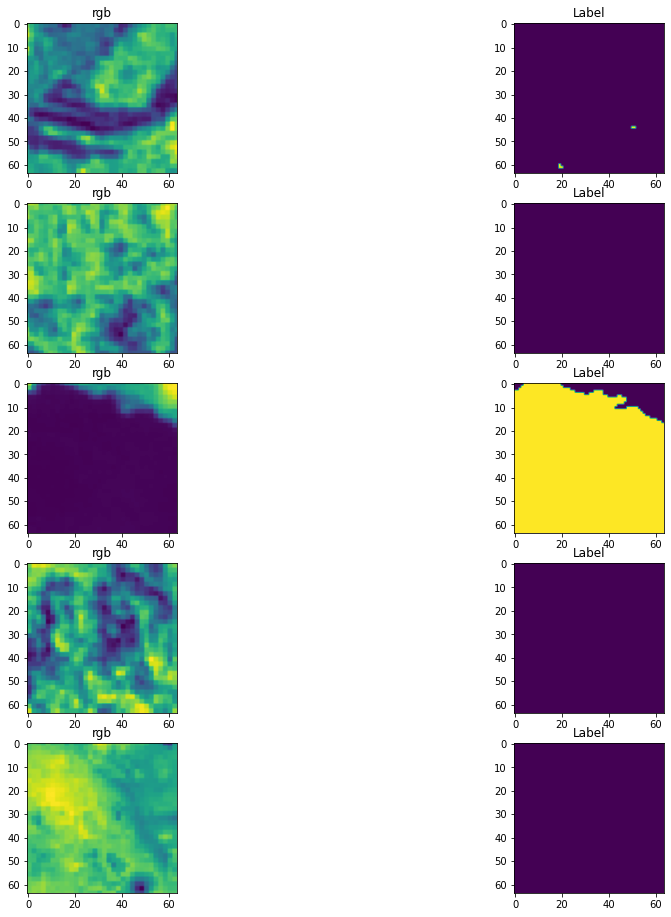

Square size (64, 64)
Value Range:  0.1598 0.2824


In [68]:
display_num = 5
plt.figure(figsize=(16, 16))

c=0
for i in range(1, display_num+1):
    for x in test_dba.take(i):
        x         
    tensor = tf.squeeze(x[0]).numpy()[:,:,0] 
    target = tf.squeeze(x[1])
    
    plt.subplot(display_num, 2, c + 1)
    plt.imshow(tensor)
    plt.title("rgb")

    plt.subplot(display_num, 2, c + 2)
    plt.imshow(target)
    plt.title("Label")
    c+=2
    print('Labels of the square: ', np.unique(target))
plt.show()

# Check the square size
print('Square size', target.shape)

minVal = tf.squeeze(x[0]).numpy()[:,:,[0]].min()
maxVal = tf.squeeze(x[0]).numpy()[:,:,[0]].max()
print('Value Range: ', minVal, maxVal)

# Creating a U-NET

In [71]:
# !!! Do not forget to change square size and number of classes:

size = 64   # сторона квадрата: 16, 32, 64, 128, 256
layerNum = 3
bands = ['B3', 'B4', 'B8', 'B11']
IMG_SHAPE = (None, None, len(bands))

stds=2 #strides (how many cells filter is moved next in one step)
padding='same'

# Activation function:
activationFoo = 'relu'

def conv_block(input_tensor, num_filters):
    encoder = layers.Conv2D(num_filters, kernel_size=(3, 3), padding=padding)(input_tensor)
    encoder = layers.BatchNormalization()(encoder)
    encoder = layers.Activation(activationFoo)(encoder)
    encoder = layers.Conv2D(num_filters, kernel_size=(3, 3), padding=padding)(encoder)
    encoder = layers.BatchNormalization()(encoder)
    encoder = layers.Activation(activationFoo)(encoder)
    return encoder

def encoder_block(input_tensor, num_filters):
    encoder = conv_block(input_tensor, num_filters)
    encoder_pool = layers.MaxPooling2D(pool_size=(2, 2), strides=(stds, stds))(encoder)
    return encoder_pool, encoder

def decoder_block(input_tensor, concat_tensor, num_filters):
    decoder = layers.Conv2DTranspose(num_filters, kernel_size=(2, 2), strides=(stds, stds), padding=padding)(input_tensor)
    decoder = layers.concatenate([concat_tensor, decoder], axis=-1)
    decoder = layers.BatchNormalization()(decoder)
    decoder = layers.Activation(activationFoo)(decoder)
    decoder = layers.Conv2D(num_filters, kernel_size=(3, 3), padding=padding)(decoder)
    decoder = layers.BatchNormalization()(decoder)
    decoder = layers.Activation(activationFoo)(decoder)
    decoder = layers.Conv2D(num_filters, kernel_size=(3, 3), padding=padding)(decoder)
    decoder = layers.BatchNormalization()(decoder)
    decoder = layers.Activation(activationFoo)(decoder)
    return decoder

if size == 16:
    inputs = layers.Input(shape=IMG_SHAPE)                      # 16
    encoder0_pool, encoder0 = encoder_block(inputs, 32)         # 8
    center = conv_block(encoder0_pool, 64)                      # center
    decoder0 = decoder_block(center, encoder0, 32)              # 16

if size == 32:
    inputs = layers.Input(shape=IMG_SHAPE)                      # 32
    encoder0_pool, encoder0 = encoder_block(inputs, 32)         # 16
    encoder1_pool, encoder1 = encoder_block(encoder0_pool, 64)  # 8
    center = conv_block(encoder1_pool, 128)                     # center
    decoder1 = decoder_block(center, encoder1, 64)            # 16
    decoder0 = decoder_block(decoder1, encoder0, 32)            # 32
    
if size == 64:
    inputs = layers.Input(shape=IMG_SHAPE)                      # 64
    encoder0_pool, encoder0 = encoder_block(inputs, 32)         # 32
    encoder1_pool, encoder1 = encoder_block(encoder0_pool, 64)  # 16
    encoder2_pool, encoder2 = encoder_block(encoder1_pool, 128) # 8
    center = conv_block(encoder2_pool, 256)                    # center
    decoder2 = decoder_block(center, encoder2, 128)             # 16
    decoder1 = decoder_block(decoder2, encoder1, 64)           # 32
    decoder0 = decoder_block(decoder1, encoder0, 32)           # 64
    
if size == 128:
    inputs = layers.Input(shape=IMG_SHAPE)                      # 128
    encoder0_pool, encoder0 = encoder_block(inputs, 32)         # 64
    encoder1_pool, encoder1 = encoder_block(encoder0_pool, 64)  # 32
    encoder2_pool, encoder2 = encoder_block(encoder1_pool, 128) # 16
    encoder3_pool, encoder3 = encoder_block(encoder2_pool, 256) # 8
    center = conv_block(encoder3_pool, 1024)                    # center
    decoder3 = decoder_block(center, encoder3, 512)             # 16
    decoder2 = decoder_block(decoder3, encoder2, 256)           # 32
    decoder1 = decoder_block(decoder2, encoder1, 128)           # 64
    decoder0 = decoder_block(decoder1, encoder0, 64)            # 128

if size == 256:
    inputs = layers.Input(shape=IMG_SHAPE)                      # 256
    encoder0_pool, encoder0 = encoder_block(inputs, 32)         # 128
    encoder1_pool, encoder1 = encoder_block(encoder0_pool, 64)  # 64
    encoder2_pool, encoder2 = encoder_block(encoder1_pool, 128) # 32
    encoder3_pool, encoder3 = encoder_block(encoder2_pool, 256) # 16
    encoder4_pool, encoder4 = encoder_block(encoder3_pool, 512) # 8
    center = conv_block(encoder4_pool, 1024)                    # center
    decoder4 = decoder_block(center, encoder4, 512)             # 16
    decoder3 = decoder_block(decoder4, encoder3, 256)           # 32
    decoder2 = decoder_block(decoder3, encoder2, 128)           # 64
    decoder1 = decoder_block(decoder2, encoder1, 64)            # 128
    decoder0 = decoder_block(decoder1, encoder0, 32)            # 256
    

# activation='sigmoid' for two classes or softmax for 3+ classes:
outputs = layers.Conv2D(layerNum, (1, 1), activation='softmax')(decoder0)

# create new model:
model = models.Model(inputs=[inputs], outputs=[outputs])

In [73]:
############################### U-Net Parameters ###############################

# larger batch_size, slower the learning process
BATCH_SIZE = 64 #32
steps_per_epoch = 500
EPOCHS=3

# Optimal learning rate is about 0.0003
MAX_LEARNING_RATE=0.0015 # Begin the learning from this learning rate
MIN_LEARNING_RATE=0.00001 # Finish learning with this learning rate
LR_FACTOR = 0.2 # Coefficient to descrease the learning rate: new_lr = lr * factor

# Save trained model here:
modelPath='/home/irro/Irro_Code/model/cnn64px_28mar_{epoch:05d}.h5'#_loss{loss:2f}.h5
# Save logs here:
logs = '/home/irro/Irro_Code/logs'

############################################################################################

csvFileName = 'log' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + '.csv'
csvFilePath = os.path.join(logs, csvFileName)

# Learning history records to CSV
csv_callback = tf.keras.callbacks.CSVLogger(filename=csvFilePath, separator=';', append=False) 

# Model Optimizer:
opt = tf.keras.optimizers.Adam(learning_rate=MAX_LEARNING_RATE) 

# Model Compilation
model.compile(optimizer=opt, \
              loss=tf.keras.losses.sparse_categorical_crossentropy, \
              metrics=['accuracy', 'sparse_categorical_accuracy'])

# Save best model states during the learning process
# save_freq is a number of epochs between savings:
modCheckPoints = ModelCheckpoint(filepath=modelPath, monitor='loss', save_best_only=True, save_freq='epoch', verbose=1) #save_freq=20

# Reducing learning rate... patience is a number of epoch to stop the learning process if monitor does not improve
reduceLearnRate = ReduceLROnPlateau(monitor='loss', factor=LR_FACTOR, patience=5, min_lr=MIN_LEARNING_RATE, verbose=1)

# EarlyStop parameters:
earlyStop = EarlyStopping(monitor='loss', patience=2)

# Model Training:
history = model.fit(train_dba, \
                    epochs=EPOCHS, \
                    steps_per_epoch = steps_per_epoch, \
                    batch_size = BATCH_SIZE, \
                    callbacks=[csv_callback, modCheckPoints, reduceLearnRate, earlyStop], \
                    use_multiprocessing=False, \
                    workers=1)

Epoch 1/3
 10/500 [..............................] - ETA: 21:42 - loss: 1.2366 - accuracy: 0.4358 - sparse_categorical_accuracy: 0.4358

KeyboardInterrupt: 

In [36]:
### Save model and weights:

# model.save_weights('/home/irro/Irro_Code/model/cnn64px_21mar_weights.h5')
# model.save('/home/irro/Irro_Code/model/cnn64px_28mar_1SToption_10e500st.h5')

In [74]:
%pylab inline
plot(history.history['loss'],'x--')
plot([i for i in history.history['sparse_categorical_accuracy']], 'o--')

Populating the interactive namespace from numpy and matplotlib


/home/irro/miniconda3/envs/gee/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['autumn', 'spring', 'summer', 'size', 'random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


NameError: name 'history' is not defined

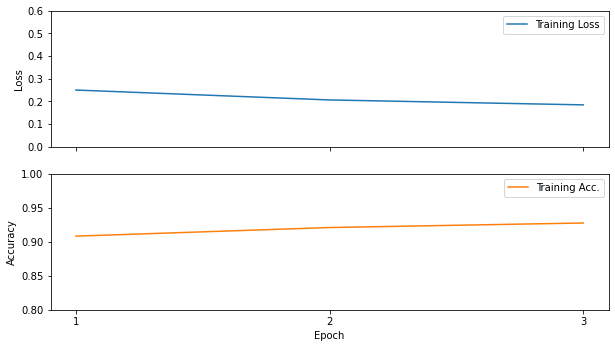

In [12]:
# plot the results of model training

fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(10,5.5))

ax[0].plot(history.history['loss'],color='#1f77b4',label='Training Loss')
# ax[0].plot(history.history['val_loss'],linestyle=':',marker='o',markersize=3,color='#1f77b4',label='Validation Loss')
ax[0].set_ylabel('Loss')
ax[0].set_ylim(0,0.6)
ax[0].legend()

ax[1].plot(history.history['sparse_categorical_accuracy'],color='#ff7f0e',label='Training Acc.')
# ax[1].plot(history.history['val_sparse_categorical_accuracy'],linestyle=':',marker='o',markersize=3,color='#ff7f0e',label='Validation Acc.')
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].legend(loc="lower right")

ax[1].set_xticks(history.epoch)
ax[1].set_xticklabels(range(1,len(history.epoch)+1))
ax[1].set_xlabel('Epoch')
ax[1].set_ylim(0.8,1)

plt.legend()

# plt.savefig("/content/drive/My Drive/landsat_qa_samples/training.png",dpi=300,)

plt.show()

In [82]:
### Load model and weights if needed:

modelPath='/home/irro/Irro_Code/model/cnn64px_28mar_1SToption_10e500st.h5'
model = keras.models.load_model(modelPath)

# model = model.load_weights('/home/irro/Irro_Code/model/cnn64px_21mar_weights.h5')

# U-Net predictions on Sentinel-2

### Test model predictions on a single image:

Initial data shape:  (2503, 2501, 4)
Final data shape:  (1, 2496, 2496, 4)


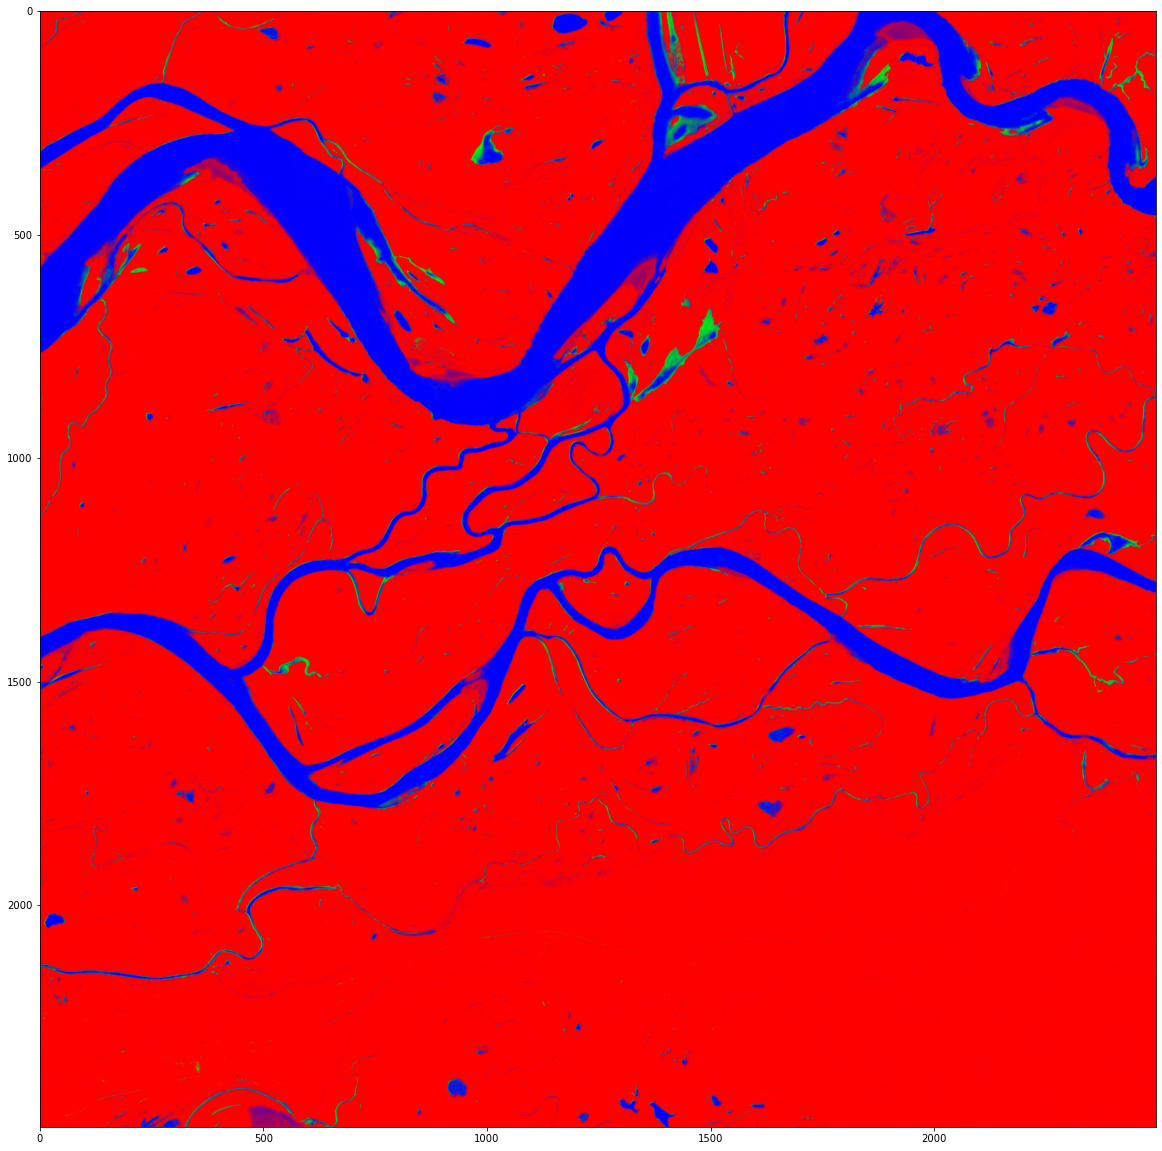

In [83]:
### Change the path to your tiled Sentinel-2 images:
imgpath = '/media/irro/GIS/SE2/SE2_squares/076.tif'
outName='/media/irro/GIS/SE2/076-cnn32.tif'

data = tiff.imread(imgpath)
# Check and change (if needed) the channel order!
# The order should be strictly the same as used in the model!!!
data = data[:,:,[3,0,1,2]] 
print("Initial data shape: ", data.shape)

# Remove extra pixels to have: total number // 32 = 0
removeColsnum = data.shape[0]%32 # number of columns to remove
removeRowsnum = data.shape[1]%32 # number of strings to remove

data1 = np.array([data[:-removeColsnum, :-removeRowsnum, :],])
print("Final data shape: ", data1.shape)

# Classification of Sentinel-2 image using U-Net:
predictions = model.predict(data1)
p = predictions.squeeze()#.shape

# Prediction vizualization:
plt.figure(figsize=(20, 30))
plt.imshow(p)
plt.show()

# Image Classification from the local folder

In [94]:
# !!! Change the number of classes if needed:
clasNum=3

# !!! Change the path to your folder with tiled Sentinel-2 images:
SE2path = '/media/irro/GIS/SE2/SE2_squares/*.tif'

# Count the number of all files in the folder:
number=0
for f in glob(SE2path):
    number += 1
print('Number of tif files:', number)

imagePath='/media/irro/GIS/SE2/SE2_squares/'
exportFilesList = [os.path.join(imagePath,files) for files in os.listdir(imagePath)] #if files.endswith(".tfrecord.gz")]
print('\nFirst 10 files: ', exportFilesList[1:10])

Number of tif files: 97

First 10 files:  ['/media/irro/GIS/SE2/SE2_squares/001.tif', '/media/irro/GIS/SE2/SE2_squares/002.tif', '/media/irro/GIS/SE2/SE2_squares/003.tif', '/media/irro/GIS/SE2/SE2_squares/004.tif', '/media/irro/GIS/SE2/SE2_squares/005.tif', '/media/irro/GIS/SE2/SE2_squares/006.tif', '/media/irro/GIS/SE2/SE2_squares/007.tif', '/media/irro/GIS/SE2/SE2_squares/008.tif', '/media/irro/GIS/SE2/SE2_squares/009.tif']


### Function to save the classified Sentinel-2

In [18]:
def classify_tif(path):     
    print(path)
    data = tiff.imread(path)
    # Check and change (if needed) the channel order!
    # The order should be strictly the same as used in the model!!!
    print("Initial data shape: ", data.shape)
    data = data[:,:,[3,0,1,2]]
    
    # Remove extra pixels to have: total number // 32 = 0
    removeColsnum = data.shape[0]%32 # number of columns to remove
    removeRowsnum = data.shape[1]%32 # number of strings to remove
    
    data1 = np.array([data[:-removeColsnum, :-removeRowsnum, :],])
    print("Data shape for prediction: ", data1.shape)
    
    # Classification of Sentinel-2 image using U-Net:
    predictions = model.predict(data1)
    
    band = predictions.squeeze() # transform predictions into 2D matrix
    shape = band.shape
    cols = shape[0]
    rows = shape[1]
    
    # Restore pixels that were previously deleted:
    image = np.zeros(shape=(cols + removeColsnum, rows + removeRowsnum, clasNum), dtype=np.float32)
    image[0:cols, 0:rows] = band
    print('Final shape: ', image.shape)
    
    # Save the final classified raster
    # Export projection from the initial image:
    myimage = rasterio.open(path)
    export_properties = myimage.profile
    # Update export properties:
    export_properties.update(
        dtype=rasterio.float64,
        count=clasNum,
        compress='lzw')
    
    # The name of the final raster:
    outName=str(path)+str('_1stoption_cnn64px')
    
    # Save raster and close the writer:
    outImage = rasterio.open(outName,'w', **export_properties)    
    for i in range(0, clasNum):
        outImage.write(image[:,:,i].astype(rasterio.float64), i+1)        
    outImage.close()

### Batch classification of all Sentinel-2 tiles in the local folder

In [19]:
for path in exportFilesList:
    task = classify_tif(path)
    print('Path:', path)    

/media/irro/GIS1/SE2/SE2_squares/000.tif
(2503, 2501, 5)
7
5
(1, 2496, 2496, 4)
2496 2496
(2503, 2501, 3)
(2503, 2501, 3)
Path: /media/irro/GIS1/SE2/SE2_squares/000.tif
/media/irro/GIS1/SE2/SE2_squares/001.tif
(2503, 2501, 5)
7
5
(1, 2496, 2496, 4)
2496 2496
(2503, 2501, 3)
(2503, 2501, 3)
Path: /media/irro/GIS1/SE2/SE2_squares/001.tif
/media/irro/GIS1/SE2/SE2_squares/002.tif
(2503, 2501, 5)
7
5
(1, 2496, 2496, 4)
2496 2496
(2503, 2501, 3)
(2503, 2501, 3)
Path: /media/irro/GIS1/SE2/SE2_squares/002.tif
/media/irro/GIS1/SE2/SE2_squares/003.tif
(2503, 2501, 5)
7
5
(1, 2496, 2496, 4)
2496 2496
(2503, 2501, 3)
(2503, 2501, 3)
Path: /media/irro/GIS1/SE2/SE2_squares/003.tif
/media/irro/GIS1/SE2/SE2_squares/004.tif
(2503, 2501, 5)
7
5
(1, 2496, 2496, 4)
2496 2496
(2503, 2501, 3)
(2503, 2501, 3)
Path: /media/irro/GIS1/SE2/SE2_squares/004.tif
/media/irro/GIS1/SE2/SE2_squares/005.tif
(2503, 2501, 5)
7
5
(1, 2496, 2496, 4)
2496 2496
(2503, 2501, 3)
(2503, 2501, 3)
Path: /media/irro/GIS1/SE2/SE2_sq

Path: /media/irro/GIS1/SE2/SE2_squares/021.tif
/media/irro/GIS1/SE2/SE2_squares/031.tif
(2501, 2501, 5)
5
5
(1, 2496, 2496, 4)
2496 2496
(2501, 2501, 3)
(2501, 2501, 3)
Path: /media/irro/GIS1/SE2/SE2_squares/031.tif
/media/irro/GIS1/SE2/SE2_squares/041.tif
(2503, 2501, 5)
7
5
(1, 2496, 2496, 4)
2496 2496
(2503, 2501, 3)
(2503, 2501, 3)
Path: /media/irro/GIS1/SE2/SE2_squares/041.tif
/media/irro/GIS1/SE2/SE2_squares/051.tif
(2501, 2501, 5)
5
5
(1, 2496, 2496, 4)
2496 2496
(2501, 2501, 3)
(2501, 2501, 3)
Path: /media/irro/GIS1/SE2/SE2_squares/051.tif
/media/irro/GIS1/SE2/SE2_squares/065.tif
(2501, 2501, 5)
5
5
(1, 2496, 2496, 4)
2496 2496
(2501, 2501, 3)
(2501, 2501, 3)
Path: /media/irro/GIS1/SE2/SE2_squares/065.tif
/media/irro/GIS1/SE2/SE2_squares/075.tif
(2503, 2501, 5)
7
5
(1, 2496, 2496, 4)
2496 2496
(2503, 2501, 3)
(2503, 2501, 3)
Path: /media/irro/GIS1/SE2/SE2_squares/075.tif
/media/irro/GIS1/SE2/SE2_squares/087.tif
(2501, 2501, 5)
5
5
(1, 2496, 2496, 4)
2496 2496
(2501, 2501, 3)
(2

### Rename files (if needed)

In [75]:
path = '/media/irro/GIS/SE2/CNN64px-1stoption-30mar/'
files = os.listdir(path)

for index, file in enumerate(files):
    os.rename(os.path.join(path, file), os.path.join(path, '_seeps_64px_1stoption'.join([str(index), '.tif'])))

# Area Calculations (important: check projection!)

In [99]:
### !!! Change the folder of classified Sentinel-2 images:
path = '/media/irro/GIS/SE2/CNN64px-1stoption-30mar/*'

# Count the number of all files in the folder:
number=0
for f in glob(path):
    number += 1
print('Number of tif-files:', number)

imagePath='/media/irro/GIS/SE2/CNN64px-1stoption-30mar'
exportFilesList = [os.path.join(imagePath,files) for files in os.listdir(imagePath)] #if files.endswith(".tfrecord.gz")]
print('First 10 files: ', exportFilesList[0:10])

Number of tif-files: 97
First 10 files:  ['/media/irro/GIS/SE2/CNN64px-1stoption-30mar/19_seeps_64px_1stoption.tif', '/media/irro/GIS/SE2/CNN64px-1stoption-30mar/1_seeps_64px_1stoption.tif', '/media/irro/GIS/SE2/CNN64px-1stoption-30mar/20_seeps_64px_1stoption.tif', '/media/irro/GIS/SE2/CNN64px-1stoption-30mar/21_seeps_64px_1stoption.tif', '/media/irro/GIS/SE2/CNN64px-1stoption-30mar/22_seeps_64px_1stoption.tif', '/media/irro/GIS/SE2/CNN64px-1stoption-30mar/23_seeps_64px_1stoption.tif', '/media/irro/GIS/SE2/CNN64px-1stoption-30mar/24_seeps_64px_1stoption.tif', '/media/irro/GIS/SE2/CNN64px-1stoption-30mar/25_seeps_64px_1stoption.tif', '/media/irro/GIS/SE2/CNN64px-1stoption-30mar/26_seeps_64px_1stoption.tif', '/media/irro/GIS/SE2/CNN64px-1stoption-30mar/27_seeps_64px_1stoption.tif']


In [131]:
i=0 
# Assign dataframes with our labels
df_no = pd.DataFrame(columns=['Img', 'classes_no', 'counts_no','area']) # class other
df_water = pd.DataFrame(columns=['Img', 'classes_no', 'counts_no','area']) # class water
df_seeps = pd.DataFrame(columns=['Img', 'classes_no', 'counts_no','area']) # class seeps
df_coords = pd.DataFrame(columns=['Img', 'left','bottom','right','top']) # coordinates of each tile

left = []
bottom = []
right = []
top = []
name = []

# Open each file in exportFilesList to append empty dataframes with area data:
for f in exportFilesList:
    
    myimage = rasterio.open(f)
    file_name = os.path.basename(f)
    index_of_dot = file_name.index('.tif')
    file_name = file_name[:index_of_dot]
    print('\nArea calculations for ', file_name)
    
    left.append(myimage.bounds[0])
    bottom.append(myimage.bounds[1])
    right.append(myimage.bounds[2])
    top.append(myimage.bounds[3])
    
    xsize = myimage.profile.get('transform')[0]
    ysize = myimage.profile.get('transform')[4] * -1
    
    pixelArea = xsize * ysize
    print('Pixel area (m^2): ', pixelArea)
        
    nothing = myimage.read(1)
    seeps = myimage.read(2)
    water = myimage.read(3)
    
    nothing2 = np.round(nothing,1)
    seeps2 = np.round(seeps,2)
    water2 = np.round(water,2)
    
    classes_no, counts_no = np.unique(nothing2, return_counts=True)
    classes_seeps, counts_seeps = np.unique(seeps2, return_counts=True)
    classes_water, counts_water = np.unique(water2, return_counts=True)
    
    name = np.full(classes_no.shape, file_name)
    result_no = pd.DataFrame(zip(name, classes_no, counts_no, counts_no * pixelArea), columns = ['Img', 'classes_no', 'counts_no','area'])
    df_no = result_no.append(df_no)   
    print('Other area, m2:', round(df_no[df_no.classes_no > 0.1].area.sum()))
    
    name = np.full(classes_seeps.shape, file_name)
    result_seeps = pd.DataFrame(zip(name, classes_seeps, counts_seeps, counts_seeps * pixelArea), columns = ['Img', 'classes_seeps', 'counts_seeps','area'])
    df_seeps = result_seeps.append(df_seeps)     
    print('Seep area, m2:', round(df_seeps[df_seeps.classes_seeps > 0.1].area.sum()))
    
    name = np.full(classes_water.shape, file_name)
    result_water = pd.DataFrame(zip(name, classes_water, counts_water, counts_water * pixelArea), columns = ['Img', 'classes_water', 'counts_water','area'])
    df_water = result_water.append(df_water)      
    print('Water area, m2:', round(df_water[df_water.classes_water > 0.1].area.sum()))
  
    # Create a Pandas Excel writer using XlsxWriter as the engine.
    writer = pd.ExcelWriter('/home/irro/Irro_Code/seepareas_1stoption_cnn64px_v2.xlsx', engine='xlsxwriter') 
    
#     Write each dataframe to a different worksheet.
    df_no.to_excel(writer, sheet_name='df_no', index=False, header=True)   
    df_seeps.to_excel(writer, sheet_name='df_seeps', index=False, header=True)
    df_water.to_excel(writer, sheet_name='df_water', index=False, header=True)  
    
    # Close the Pandas Excel writer and output the Excel file.
    writer.save()


Area calculations for  19_seeps_64px_1stoption
Pixel area (m^2):  100.0
Other area, m2: 621094500
Seep area, m2: 724400
Water area, m2: 5492300

Area calculations for  1_seeps_64px_1stoption
Pixel area (m^2):  100.0
Other area, m2: 1180863100
Seep area, m2: 23090500
Water area, m2: 103805400

Area calculations for  20_seeps_64px_1stoption
Pixel area (m^2):  100.0
Other area, m2: 1793343900
Seep area, m2: 28038900
Water area, m2: 125867100

Area calculations for  21_seeps_64px_1stoption
Pixel area (m^2):  100.0
Other area, m2: 2385888200
Seep area, m2: 43982300
Water area, m2: 183366300

Area calculations for  22_seeps_64px_1stoption
Pixel area (m^2):  100.0


KeyboardInterrupt: 

### DataFrame with coordinates of each tile

In [134]:
coords = [left, bottom, right, top]
df = pd.DataFrame(zip(name, left, bottom, right, top), columns=['name', 'left','bottom','right', 'top'])
print('Check first tiles: ')
print(df[0:10].head())
df.to_excel(r'/home/irro/Irro_Code/seepareas_1stoption_cnn64px_coords.xlsx', index = False)

Check first tiles: 
                      name      left     bottom     right        top
0  21_seeps_64px_1stoption  327650.0  6864370.0  352660.0  6889400.0
1  21_seeps_64px_1stoption  527650.0  6714370.0  552660.0  6739400.0
2  21_seeps_64px_1stoption  352650.0  6864370.0  377660.0  6889400.0
3  21_seeps_64px_1stoption  377650.0  6864370.0  402660.0  6889400.0
4  21_seeps_64px_1stoption  702650.0  6714370.0  727660.0  6739400.0


# Accuracy Assessment 

## Transform Probability to Label

In [139]:
path = "/media/irro/Data/SE2_squares/cnn64px-1stoption-2apr.tif"

In [140]:
gdf = gpd.read_file("/media/irro/GIS/Shapes/test_points_cnn64_balanced2000points/test_points_cnn64_balanced2000points.shp")
print(gdf.crs)
gdf_repr = gdf.to_crs("EPSG:32642") # world.to_crs(epsg=3395) would also work
print(gdf_repr.crs)

epsg:4326
EPSG:32642


U-Net gives a probability of each label... so you first need to get probability values and represent them in the dataframe. Then you need to find a threshold values of probabilities (e.g. water > 20% means water class, seeps > 60% means seep class and so on).

In [141]:
# Read the classified image with probabilities and transform all values into the dataframe:

gdf_repr['max-1band'] = pd.DataFrame(
    rs.zonal_stats(
        vectors=gdf_repr['geometry'], 
        raster=path, 
        band=1,
        stats=['max']
    )
)['max']

gdf_repr['max-2band'] = pd.DataFrame(
    rs.zonal_stats(
        vectors=gdf_repr['geometry'], 
        raster=path, 
        band=2,
        stats=['max']
    )
)['max']

gdf_repr['max-3band'] = pd.DataFrame(
    rs.zonal_stats(
        vectors=gdf_repr['geometry'], 
        raster=path, 
        band=3,
        stats=['max']
    )
)['max']

/home/irro/miniconda3/envs/gee/lib/python3.8/site-packages/rasterstats/io.py:302: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


In [145]:
# Check the values! Sum of probabilities of different labels should be 1:
a = (gdf_repr['max-1band'][10]+gdf_repr['max-2band'][10]+gdf_repr['max-3band'][10])
print(a)

# 'max-1band' - class Other
# 'max-2band' - class Seeps
# 'max-3band' - class Water

0.9999999776482582


In [147]:
# Check the DataFrame itself

print(gdf_repr[0:5])
print(gdf_repr.head())

# "max-1band" means probability of 1st class (Other) and so on
# "label" means the REAL label by test points

   label                        geometry  max-1band  max-2band  max-3band
0      1  POINT (706705.102 6750079.012)   0.004378   0.354620   0.641002
1      1  POINT (525967.488 6772609.801)   0.118195   0.720830   0.160975
2      1  POINT (547306.831 6692281.811)   0.292643   0.291701   0.415656
3      1  POINT (526298.768 6771995.314)   0.252682   0.381550   0.365768
4      1  POINT (475892.408 6758509.159)   0.368063   0.360746   0.271192
   label                        geometry  max-1band  max-2band  max-3band
0      1  POINT (706705.102 6750079.012)   0.004378   0.354620   0.641002
1      1  POINT (525967.488 6772609.801)   0.118195   0.720830   0.160975
2      1  POINT (547306.831 6692281.811)   0.292643   0.291701   0.415656
3      1  POINT (526298.768 6771995.314)   0.252682   0.381550   0.365768
4      1  POINT (475892.408 6758509.159)   0.368063   0.360746   0.271192


### Accuracy Assessment for U-Net map

In [154]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, cohen_kappa_score
label = []

### !!! IMPORTANT: Thresholds were found in the next section and inserted here manually!!!

for index, row in gdf_repr.iterrows():
    if row['max-3band']>0.2 and row['max-2band']<0.2:
        label.append(2) # Вода
    elif row['max-2band']>0.2:
        label.append(1) # Сипы    
    elif row['max-1band']>0.5:
        label.append(0)
    else:
        label.append(0) 
gdf_repr['test_label'] = pd.Series(label)
y_pred = label
y_true = gdf_repr['label'].to_list()

Accuracy_score:  0.8256666666666667
Kappa:  0.7384999999999999


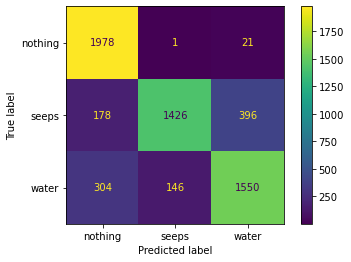

In [155]:
cm = confusion_matrix(y_true, y_pred)
acc = accuracy_score(y_true, y_pred)
# print('confusion_matrix:\n', cm)
print('Accuracy_score: ', acc)
display_labels=['nothing', 'seeps', 'water']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['nothing', 'seeps', 'water'])
disp.plot() 
kappa = cohen_kappa_score(y_true, y_pred)
print('Kappa: ', kappa)

In [153]:
from sklearn.metrics import classification_report
target_names=['Nothing', 'Seeps', 'Water']
report = classification_report(y_true, y_pred, target_names=target_names)
print(report)

              precision    recall  f1-score   support

     Nothing       0.80      0.99      0.89      2000
       Seeps       0.91      0.71      0.80      2000
       Water       0.79      0.78      0.78      2000

    accuracy                           0.83      6000
   macro avg       0.83      0.83      0.82      6000
weighted avg       0.83      0.83      0.82      6000



### Minimization of Kappa to find the best threshold values of probabilities

In [157]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, cohen_kappa_score
y_true_cm = gdf_repr['label'].to_list() # Реальный лейбл

def func_acc(x): 
    cm_label = []
    for index, row in gdf_repr.iterrows():
        if row['max-3band']>x[0] and row['max-2band']<x[3]:
            cm_label.append(2) # Вода
        elif row['max-2band']>x[1]:
            cm_label.append(1) # Сипы        
        elif row['max-1band']>x[2]:
            cm_label.append(0) # Ничего
        else:
            cm_label.append(0)           
        
    y_pred_cm = cm_label # Лейбл, предксказанный по трешолдам
    
    cm = confusion_matrix(y_true_cm, y_pred_cm)
    acc = accuracy_score(y_true_cm, y_pred_cm)
    
    print('confusion_matrix:\n', cm)
    print('\naccuracy_score', acc)
    
    kappa = cohen_kappa_score(y_true_cm, y_pred_cm)
    antikappa = 1-kappa
    print('\nKappa: ', kappa)
    print('Water probability threshold: ', x[0])
    print('Seeps probability threshold: ', x[1])
    print('Other probability threshold ', x[2])
    print('One more water probability threshold: ', x[3])
    return antikappa

In [158]:
from scipy.optimize import minimize

# start values for minimization
x0 = [0.5,0.5,0.5,0.5]
minimize(func_acc, x0, method='COBYLA',constraints = {'type':'ineq', 'fun': lambda x: x},tol=None, callback=None)

confusion_matrix:
 [[2000    0    0]
 [ 405  779  816]
 [ 405    0 1595]]

accuracy_score 0.729

Kappa:  0.5935
Water probability threshold:  0.5
Seeps probability threshold:  0.5
Other probability threshold  0.5
One more water probability threshold:  0.5
confusion_matrix:
 [[2000    0    0]
 [1221  779    0]
 [2000    0    0]]

accuracy_score 0.46316666666666667

Kappa:  0.19474999999999987
Water probability threshold:  1.5
Seeps probability threshold:  0.5
Other probability threshold  0.5
One more water probability threshold:  0.5
confusion_matrix:
 [[2000    0    0]
 [1184    0  816]
 [ 405    0 1595]]

accuracy_score 0.5991666666666666

Kappa:  0.39875000000000005
Water probability threshold:  0.5
Seeps probability threshold:  1.5
Other probability threshold  0.5
One more water probability threshold:  0.5
confusion_matrix:
 [[2000    0    0]
 [ 405  779  816]
 [ 405    0 1595]]

accuracy_score 0.729

Kappa:  0.5935
Water probability threshold:  0.5
Seeps probability threshold:  0.5

confusion_matrix:
 [[1979    1   20]
 [ 180 1395  425]
 [ 305  140 1555]]

accuracy_score 0.8215

Kappa:  0.7322500000000001
Water probability threshold:  0.21720000479083557
Seeps probability threshold:  0.19891084983275775
Other probability threshold  0.5088122684439594
One more water probability threshold:  0.21824279198138238
confusion_matrix:
 [[1978    1   21]
 [ 173 1379  448]
 [ 304  126 1570]]

accuracy_score 0.8211666666666667

Kappa:  0.73175
Water probability threshold:  0.1963810671857343
Seeps probability threshold:  0.18113283292067128
Other probability threshold  0.513730685612028
One more water probability threshold:  0.2324865844619445
confusion_matrix:
 [[1979    1   20]
 [ 177 1425  398]
 [ 305  144 1551]]

accuracy_score 0.8258333333333333

Kappa:  0.73875
Water probability threshold:  0.21533645734478662
Seeps probability threshold:  0.19216330860611458
Other probability threshold  0.5114615150590848
One more water probability threshold:  0.20452710768626525
confu

confusion_matrix:
 [[1978    1   21]
 [ 170 1446  384]
 [ 303  152 1545]]

accuracy_score 0.8281666666666667

Kappa:  0.7422500000000001
Water probability threshold:  0.19410038899244636
Seeps probability threshold:  0.16834116101971877
Other probability threshold  0.49651943009553196
One more water probability threshold:  0.19099913330110027
confusion_matrix:
 [[1978    1   21]
 [ 170 1446  384]
 [ 303  152 1545]]

accuracy_score 0.8281666666666667

Kappa:  0.7422500000000001
Water probability threshold:  0.1942930720894848
Seeps probability threshold:  0.16825206116784935
Other probability threshold  0.49642591350299836
One more water probability threshold:  0.1911429904990525
confusion_matrix:
 [[1978    1   21]
 [ 170 1446  384]
 [ 303  153 1544]]

accuracy_score 0.828

Kappa:  0.742
Water probability threshold:  0.19431714459066662
Seeps probability threshold:  0.16828540771132816
Other probability threshold  0.4962672844852728
One more water probability threshold:  0.190924699034

     fun: 0.2577499999999999
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 58
  status: 1
 success: True
       x: array([0.19428239, 0.16819569, 0.49645942, 0.19104059])

Minimization results:
    fun: 0.2577499999999999
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 58
  status: 1
 success: True
       x: array([0.19428239, 0.16819569, 0.49645942, 0.19104059])